In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

In [227]:
data = pd.read_excel("../../data/Input data/fs_test_data.xlsx",parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3552 non-null   datetime64[ns]
 1   price      3552 non-null   float64       
 2   promotion  3552 non-null   int64         
 3   region     3552 non-null   object        
 4   type       3552 non-null   object        
 5   revenue    2720 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 166.6+ KB


In [228]:
from sklearn.preprocessing import LabelEncoder
region_encoder = LabelEncoder()
type_encoder = LabelEncoder()

data['region_encoder'] = region_encoder.fit_transform(data['region'])
data['type_encoder'] = type_encoder.fit_transform(data['type'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3552 non-null   datetime64[ns]
 1   price           3552 non-null   float64       
 2   promotion       3552 non-null   int64         
 3   region          3552 non-null   object        
 4   type            3552 non-null   object        
 5   revenue         2720 non-null   float64       
 6   region_encoder  3552 non-null   int64         
 7   type_encoder    3552 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 222.1+ KB


In [229]:
data.drop(columns = ["region", "type"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3552 non-null   datetime64[ns]
 1   price           3552 non-null   float64       
 2   promotion       3552 non-null   int64         
 3   revenue         2720 non-null   float64       
 4   region_encoder  3552 non-null   int64         
 5   type_encoder    3552 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 166.6 KB


In [230]:
data_grouped = data.groupby('Date')['revenue'].sum().reset_index()
data_grouped.set_index('Date', inplace=True)
data_grouped

,revenue
Date,
2004-02-22,49911.0
2004-02-29,38764.0
2004-03-07,35897.0
2004-03-14,33530.0
2004-03-21,34955.0
...,...
2008-04-20,0.0
2008-04-27,0.0
2008-05-04,0.0


In [231]:
train = data_grouped.loc[:'2006-05-28']
test = data_grouped.loc['2006-05-28':'2007-05-20']


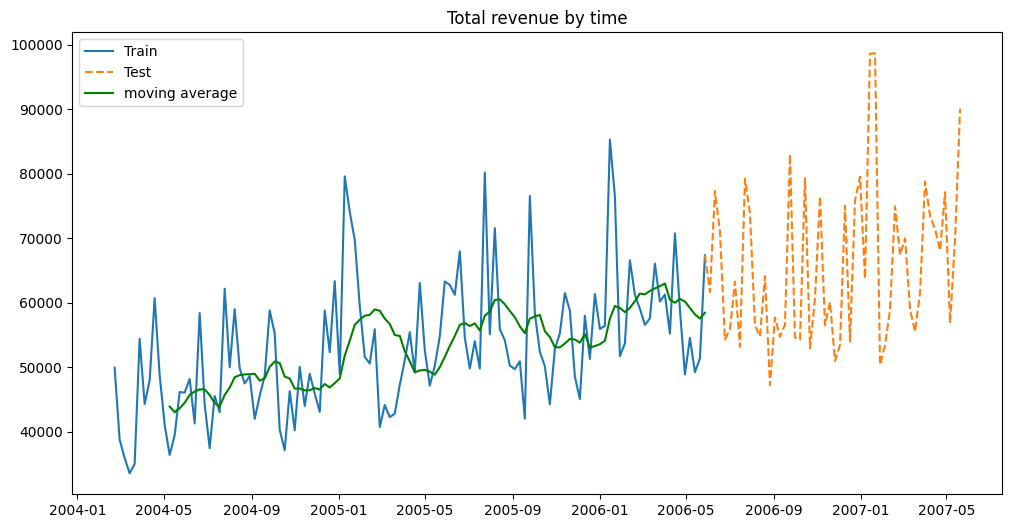

In [232]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', linestyle='dashed')
plt.plot(train.rolling(window=12).mean(),label = "moving average",color="green")
plt.legend()
plt.title('Total revenue by time')
plt.show()

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3552 non-null   datetime64[ns]
 1   price           3552 non-null   float64       
 2   promotion       3552 non-null   int64         
 3   revenue         2720 non-null   float64       
 4   region_encoder  3552 non-null   int64         
 5   type_encoder    3552 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 166.6 KB


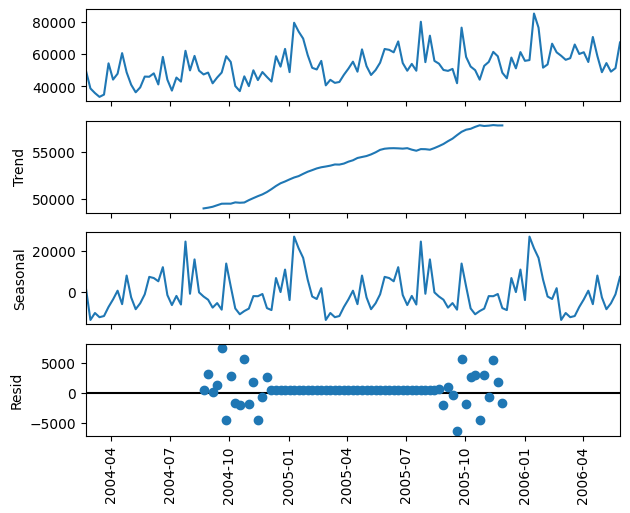

In [234]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(train)
decompose.plot()
plt.xticks(rotation = 90)
plt.show()


In [235]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train["revenue"])

print("p-value = "+str(adf_test[1]))

p-value = 9.181281122534223e-05


our p-value < 0.05 , so the time series is stationary

<function matplotlib.pyplot.show(close=None, block=None)>

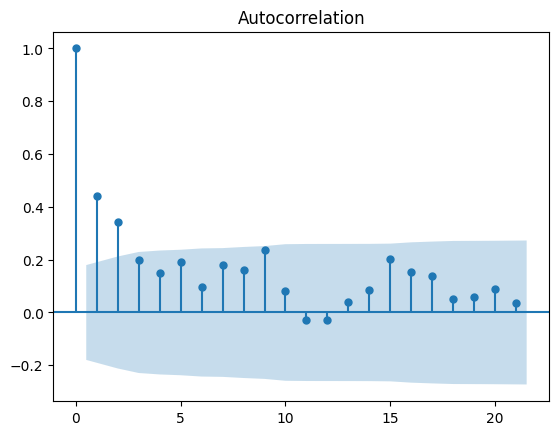

In [236]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train["revenue"])
plt.axis('tight')
plt.show

In [237]:
from statsmodels.tsa.api import ExponentialSmoothing

model = ExponentialSmoothing(
                             train,
                             trend="add",
                             seasonal="add"                 
                            )

fit_model = model.fit()

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


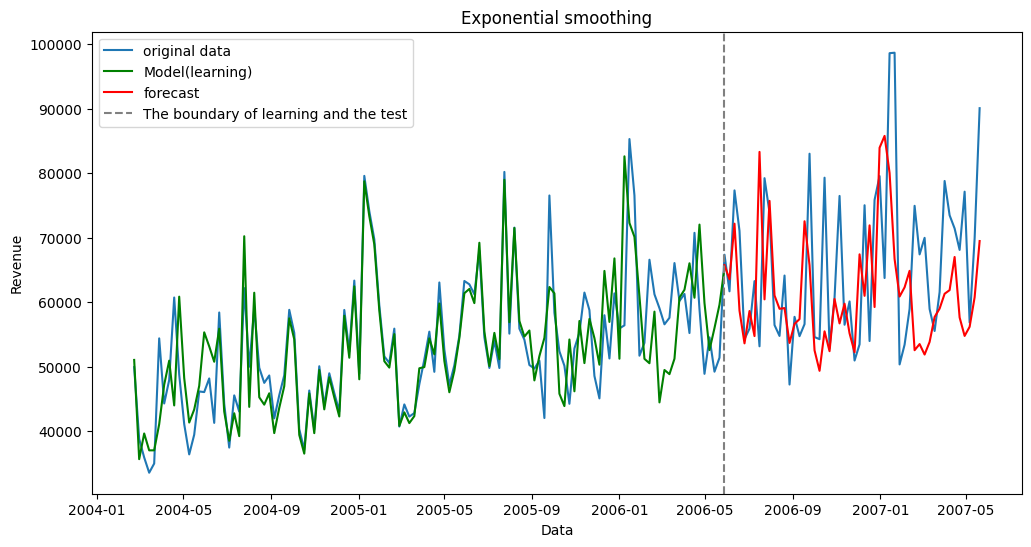

In [238]:
combined = pd.concat([train,test])
forecast = fit_model.forecast(steps = len(test))

plt.figure(figsize = (12,6))
plt.plot(combined.index, combined["revenue"],label = "original data")
plt.plot(train.index,fit_model.fittedvalues, label = "Model(learning)", color = "green")
plt.plot(test.index,forecast,label = "forecast", color = "red")
plt.axvline(x = train.index[-1],linestyle = '--', color = "gray", label = "The boundary of learning and the test")
plt.legend()
plt.title("Exponential smoothing")
plt.xlabel("Data")
plt.ylabel("Revenue")
plt.show()


In [239]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
test_flat = test.values.flatten()

mae = mean_absolute_error(test_flat,forecast)
mse = mean_squared_error(test_flat,forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_flat-forecast)/test_flat))*100


print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  10148.30
MSE:  172173663.63
RMSE: 13121.50
MAPE: 14.80%


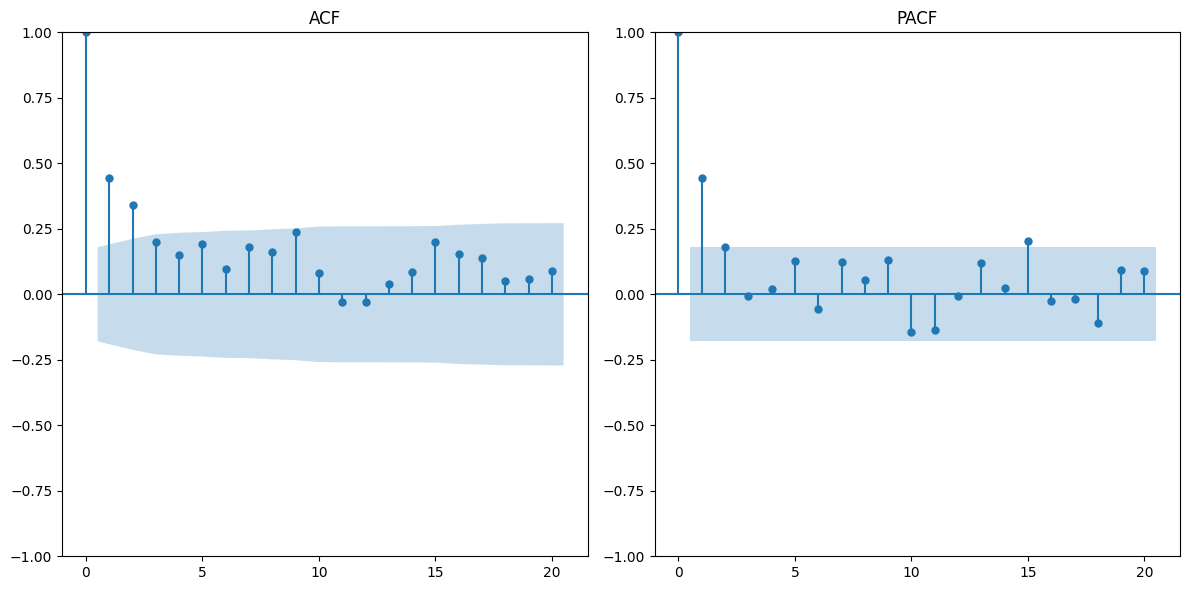

In [240]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(train, lags=20, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(train, lags=20, ax=plt.gca())
plt.title('PACF')

plt.tight_layout()
plt.show()


In [241]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(2, 0, 1))
fit_arima_model = arima_model.fit()

fit_arima_model.summary()

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  119
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1249.727
Date:                Sat, 22 Feb 2025   AIC                           2509.453
Time:                        14:21:39   BIC                           2523.349
Sample:                    02-22-2004   HQIC                          2515.096
                         - 05-28-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.307e+04   1820.798     29.144      0.000    4.95e+04    5.66e+04
ar.L1          0.3110      0.604      0.515      0.607      -0.873       1.495
ar.L2          0.2076      0.255      0.814      0.416      -0.292       0.707
ma.L1          0.0550      0.635      0.087      0.931      -1.189       1.299
sigma2      7.637e+07      0.242   3.16e+08      0.000    7.64e+07    7.64e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             1.09
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+23. Standard errors may be unstable.
"""

In [242]:
arima_forecast = fit_arima_model.forecast(steps=52)

In [243]:
test_flat = test.values.flatten()

mae = mean_absolute_error(test_flat,arima_forecast)
mse = mean_squared_error(test_flat,arima_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_flat-arima_forecast)/test_flat))*100


print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  12671.22
MSE:  297893957.40
RMSE: 17259.60
MAPE: 16.95%


In [244]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
train_log = np.log1p(train)  
test_log = np.log1p(test)

sarima_model = SARIMAX(train_log,
                order=(1,1,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=True,
                enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [245]:
sarima_forecast = sarima_result.forecast(steps = len(test_flat))

test_flat = test.values.flatten()
mae = mean_absolute_error(test_flat,sarima_forecast)
mse = mean_squared_error(test_flat,sarima_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_flat-sarima_forecast)/test_flat))*100


print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  65613.32
MSE:  4452427470.75
RMSE: 66726.51
MAPE: 99.98%


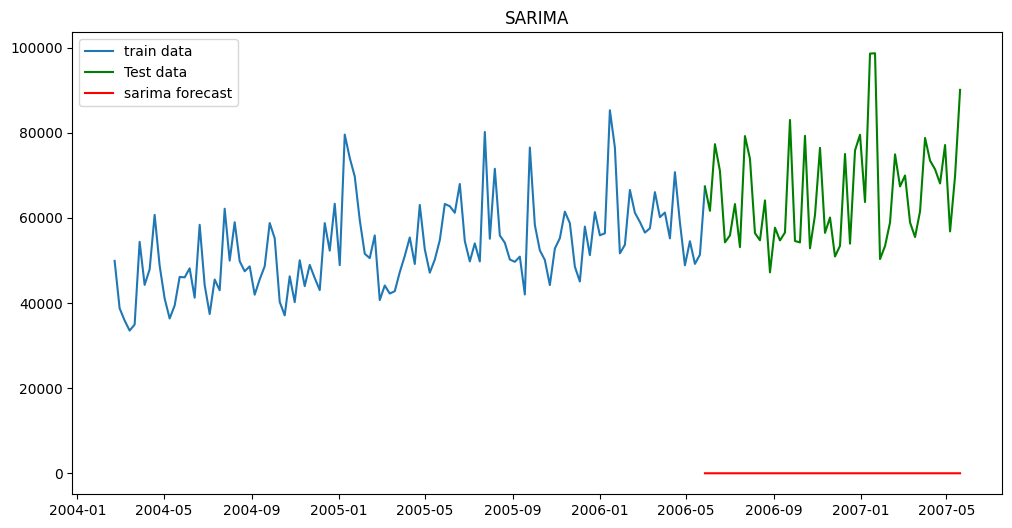

In [246]:
plt.figure(figsize = (12,6))
plt.plot(train ,label = "train data")
plt.plot(test, label = "Test data", color = "green")
plt.plot(test.index,sarima_forecast,label = "sarima forecast", color = "red")
plt.legend()
plt.title("SARIMA")
plt.show()

In [2]:
start_year = 2004
start_month = 3

In [3]:
df = pd.read_excel('../../data/Input data/fs_test_data.xlsx', parse_dates=['Date'])


df_weekly = df.groupby('Date', as_index=True).agg({
    'revenue': 'sum',
    'price': 'mean',      
    'promotion': 'sum'    
}).sort_index()

In [4]:
df_weekly.index = pd.to_datetime(df_weekly.index)

In [5]:
df_weekly['trend'] = np.arange(len(df_weekly))

In [6]:
df_weekly['month'] = df_weekly.index.month
df_weekly['year'] = df_weekly.index.year

In [7]:
month_dummies = pd.get_dummies(df_weekly['month'], prefix='m', drop_first=False).astype(int)
df_weekly = pd.concat([df_weekly, month_dummies], axis=1)
df_weekly


,revenue,price,promotion,trend,month,year,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
Date,,,,,,,,,,,,,,,,,,
2004-02-22,49911.0,62.192019,0,0,2,2004,0,1,0,0,0,0,0,0,0,0,0,0
2004-02-29,38764.0,57.337358,0,1,2,2004,0,1,0,0,0,0,0,0,0,0,0,0
2004-03-07,35897.0,41.174016,0,2,3,2004,0,0,1,0,0,0,0,0,0,0,0,0
2004-03-14,33530.0,46.340477,0,3,3,2004,0,0,1,0,0,0,0,0,0,0,0,0
2004-03-21,34955.0,44.079382,0,4,3,2004,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-04-20,0.0,40.435710,1,217,4,2008,0,0,0,1,0,0,0,0,0,0,0,0
2008-04-27,0.0,36.661676,0,218,4,2008,0,0,0,1,0,0,0,0,0,0,0,0
2008-05-04,0.0,33.157442,2,219,5,2008,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
df_weekly['log_rev'] = np.log1p(df_weekly['revenue'])

df_weekly.head()

,revenue,price,promotion,trend,month,year,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,log_rev
Date,,,,,,,,,,,,,,,,,,,
2004-02-22,49911.0,62.192019,0,0,2,2004,0,1,0,0,0,0,0,0,0,0,0,0,10.818017
2004-02-29,38764.0,57.337358,0,1,2,2004,0,1,0,0,0,0,0,0,0,0,0,0,10.565273
2004-03-07,35897.0,41.174016,0,2,3,2004,0,0,1,0,0,0,0,0,0,0,0,0,10.488437
2004-03-14,33530.0,46.340477,0,3,3,2004,0,0,1,0,0,0,0,0,0,0,0,0,10.420226
2004-03-21,34955.0,44.079382,0,4,3,2004,0,0,1,0,0,0,0,0,0,0,0,0,10.461845


In [9]:
train = df_weekly.loc[:'2006-05-27']  
test  = df_weekly.loc['2006-05-28':'2007-05-20']  

print("Train range:", train.index.min(), "->", train.index.max())
print("Test range:", test.index.min(), "->", test.index.max())


Train range: 2004-02-22 00:00:00 -> 2006-05-21 00:00:00
Test range: 2006-05-28 00:00:00 -> 2007-05-20 00:00:00


In [10]:
exog_cols = ['trend', 'price', 'promotion'] + list(month_dummies.columns)

train_X = train[exog_cols]
train_y = train['log_rev']

test_X = test[exog_cols]
test_y = test['log_rev']

In [11]:
model = SARIMAX(endog=train_y,
                exog=train_X,
                order=(1,1,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=False,
                enforce_invertibility=False)

res = model.fit(disp=False)
print(res.summary())

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                            log_rev   No. Observations:                  118
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   5.681
Date:                            Sat, 22 Feb 2025   AIC                             28.638
Time:                                    14:59:32   BIC                             36.596
Sample:                                02-22-2004   HQIC                            23.622
                                     - 05-21-2006                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend       9.787e-07    1.5e-09    650.372      0.000    9.76e-07    9.82e-07
price          0.0067      0.024   

In [12]:
pred_log = res.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X)

pred = np.expm1(pred_log)
actual = np.expm1(test_y)


mape = np.mean(np.abs((actual - pred) / actual)) * 100
print(f"MAPE on test sample: {mape:.2f}%")

MAPE on test sample: 13.02%


In [13]:
last_date = df_weekly.index.max()


future_index = pd.date_range(start='2007-05-27', periods=26, freq='W-SUN')
future_df = pd.DataFrame(index=future_index)

start_trend = df_weekly['trend'].iloc[-1] + 1
future_df['trend'] = np.arange(start_trend, start_trend + 26)

In [14]:
future_df['price'] = train['price'].mean()
future_df['promotion'] = 0

In [15]:
future_df['month'] = future_df.index.month
month_dummies_future = pd.get_dummies(future_df['month'], prefix='m', drop_first=False).astype(int)

In [16]:
month_cols = [col for col in df_weekly.columns if col.startswith('m_')]
month_dummies_future = month_dummies_future.reindex(columns=month_cols, fill_value=0)


future_df = pd.concat([future_df, month_dummies_future], axis=1)


In [17]:
future_df = future_df.reindex(columns=exog_cols, fill_value=0)
future_X = future_df[exog_cols]
future_X

,trend,price,promotion,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
2007-05-27,222,43.070148,0,0,0,0,0,1,0,0,0,0,0,0,0
2007-06-03,223,43.070148,0,0,0,0,0,0,1,0,0,0,0,0,0
2007-06-10,224,43.070148,0,0,0,0,0,0,1,0,0,0,0,0,0
2007-06-17,225,43.070148,0,0,0,0,0,0,1,0,0,0,0,0,0
2007-06-24,226,43.070148,0,0,0,0,0,0,1,0,0,0,0,0,0
2007-07-01,227,43.070148,0,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-08,228,43.070148,0,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-15,229,43.070148,0,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-22,230,43.070148,0,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-29,231,43.070148,0,0,0,0,0,0,0,1,0,0,0,0,0


In [18]:
forecast_res = res.get_forecast(steps=26, exog=future_X)
forecast_ci = forecast_res.conf_int(alpha=0.05)

In [19]:
forecast_log = forecast_res.predicted_mean

In [20]:
lower_log = forecast_ci['lower log_rev']
upper_log = forecast_ci['upper log_rev']

In [21]:
forecast = np.expm1(forecast_log)
forecast_lower = np.expm1(lower_log)
forecast_upper = np.expm1(upper_log)

In [22]:
df_forecast = pd.DataFrame({
    'forecast': forecast,
    'lower_95': forecast_lower,
    'upper_95': forecast_upper
})


In [23]:
df_forecast

,forecast,lower_95,upper_95
2006-05-28,64493.406241,48602.375567,85580.060735
2006-06-04,61546.096076,45690.429016,82903.936813
2006-06-11,55275.669622,39515.941512,77320.525593
2006-06-18,70551.285345,49138.805927,101294.169435
2006-06-25,54744.788631,37129.115575,80717.880790
2006-07-02,51429.280485,34047.191277,77685.175140
2006-07-09,56724.837343,36697.225772,87682.274996
2006-07-16,54138.815232,34268.079464,85531.486990
2006-07-23,80742.018189,50052.621692,130248.016274
2006-07-30,55936.840318,33989.886840,92054.320422


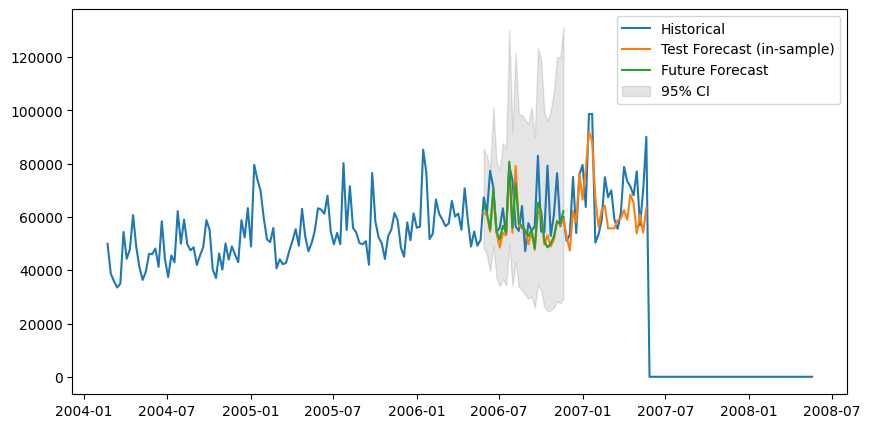

In [24]:
plt.figure(figsize=(10,5))
plt.plot(df_weekly.index, np.expm1(df_weekly['log_rev']), label='Historical')
plt.plot(test.index, pred, label='Test Forecast (in-sample)')
plt.plot(df_forecast.index, df_forecast['forecast'], label='Future Forecast')
plt.fill_between(df_forecast.index,
                 df_forecast['lower_95'],
                 df_forecast['upper_95'],
                 color='k', alpha=0.1, label='95% CI')
plt.legend()
plt.show()